# Деревья решений 
В этом задании предстоит реализовать очень полезный метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений. Кроме того, этот метод часто используется в случаях, когда интерпретируемость модели имеет большое значение, например, в чувствительных задачах 

In [1]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib

Основная идея любого алгоритма дерева решений заключается в следующем: 
1. Выберите лучший атрибут, используя меры выбора атрибута (ASM), чтобы разделить примеры. 
2.  Сделайте этот атрибут узлом решения и разбейте набор данных на более мелкие подмножества. 
3. Начните построение дерева, рекурсивно повторяя этот процесс для каждого дочернего элемента, пока не совпадет одно из условий:
   1. Все кортежи принадлежат одному и тому же значению атрибута. 
   2. Оставшихся атрибутов больше нет. 
   3. Больше нет примеров

## Использование различных моделей

Протестируем решение на датасетах [mushrooms](https://www.kaggle.com/datasets/uciml/mushroom-classification) и diabetes?.
1. Выполним загрузку и предобработку данных.
2. Разобьем данные на тренировочный и валидационный набор для оценки точности работы алгоритма.
3. Посчитаем метрики для различных параметров построения дерева

In [2]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
with open('../config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

Начнем с WDBC. В этом датасете хранятся геометрические и прочие внешние признаки опухолей (вероятно, полученные из МРТ). Опухоли будут быть доброкачественными (benign = B) и злокачественными (malignant = M). Задача состоит в определении типа опухоли по данным признакам

In [4]:
df = pd.read_csv("D:\\spbu-ai-fundamentals\\practicum_7\\wdbc\\data.csv")

Как обычно, отбрасываем идентификатор

In [5]:
df = df.drop(['id', 'Unnamed: 32'], axis=1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Трансформируем строковые категории B и M в числовые 0 и 1, после чего разделяем признаки и таргет, который будем предсказывать. Это дает нам датафреймы X и y соответственно.

In [6]:
df['diagnosis'] = df['diagnosis'].replace({'B': 0, 'M': 1}).astype(int)
target = 'diagnosis'
features = list(df.columns)
features.remove('diagnosis')
features

C:\Users\Abara\AppData\Local\Temp\ipykernel_7556\3186978791.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diagnosis'] = df['diagnosis'].replace({'B': 0, 'M': 1}).astype(int)


['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [7]:
X_diagnosis = df[features]
y_diagnosis = df[[target]]

Рассмотрим теперь датасет mushrooms. В нем содержатся геометрические и прочие внешние признаки грибов, которые классифицируются на съедобные и ядовитые. Наша задача состоит в подобной классификации по данным признакам

In [8]:
df = pd.read_csv("D:\\spbu-ai-fundamentals\\practicum_7.5\\mushrooms\\mushrooms.csv")
target = 'class'
features = list(df.columns)
features.remove(target)
X_mushroom = df[features]
y_mushroom = df[[target]]
X_mushroom.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


**Задание**: Проведите краткий EDA. Есть ли выбросы в данных, как связаны столбцы? Хватит 2-3 графиков или таблиц (но можно больше). Какие есть типы признаков в этом датасете?

In [9]:
X_mushroom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                8124 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

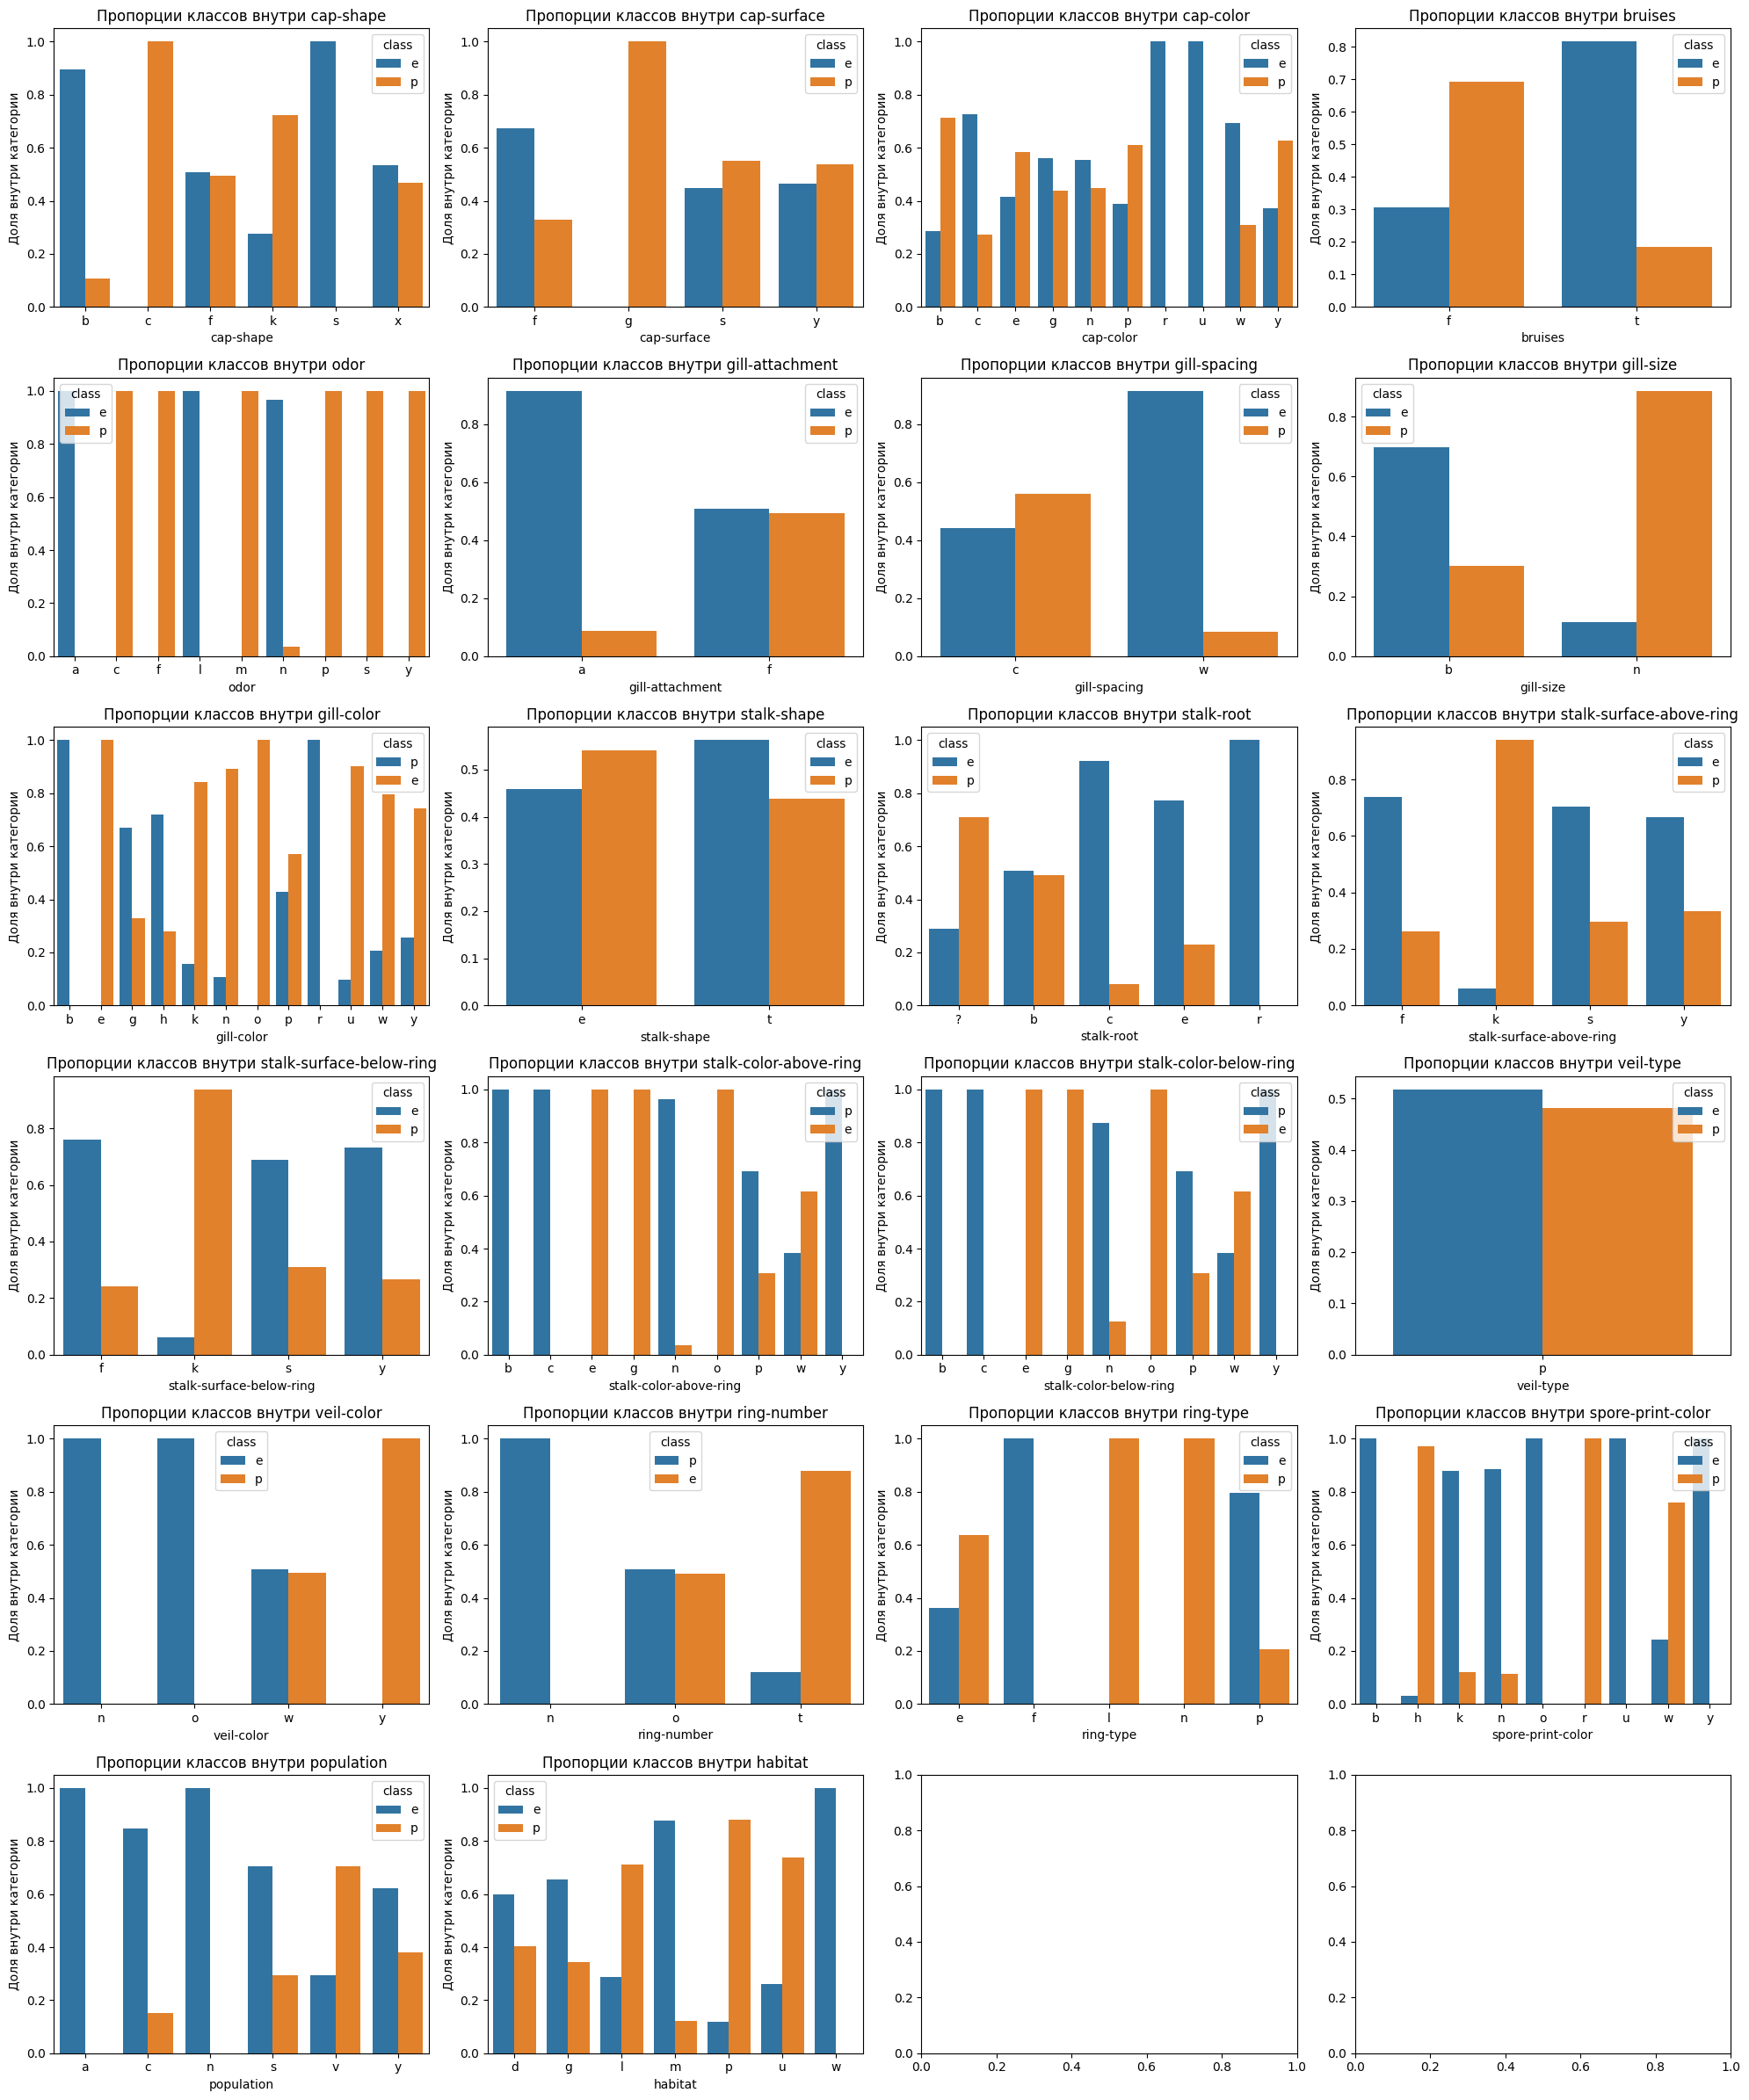

In [10]:
import seaborn as sns 

features = list(X_mushroom)
n = len(features)

fig, axes = plt.subplots(6, 4, figsize=(20, 4 * 6))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    prop_df = (
        df.groupby([feature, 'class'])
          .size()
          .reset_index(name='count')
    )
    total_per_category = prop_df.groupby(feature)['count'].transform('sum')
    prop_df['proportion'] = prop_df['count'] / total_per_category

    sns.barplot(data=prop_df, x=feature, y='proportion', hue='class', ax=ax)
    ax.set_title(f'Пропорции классов внутри {feature}')
    ax.set_ylabel('Доля внутри категории')

plt.tight_layout()

_Эти бар-плоты показывают пропорции по классам грибов для каждого признака. Можно увидеть сильные предикторы, например, один из самых показательных - odor._

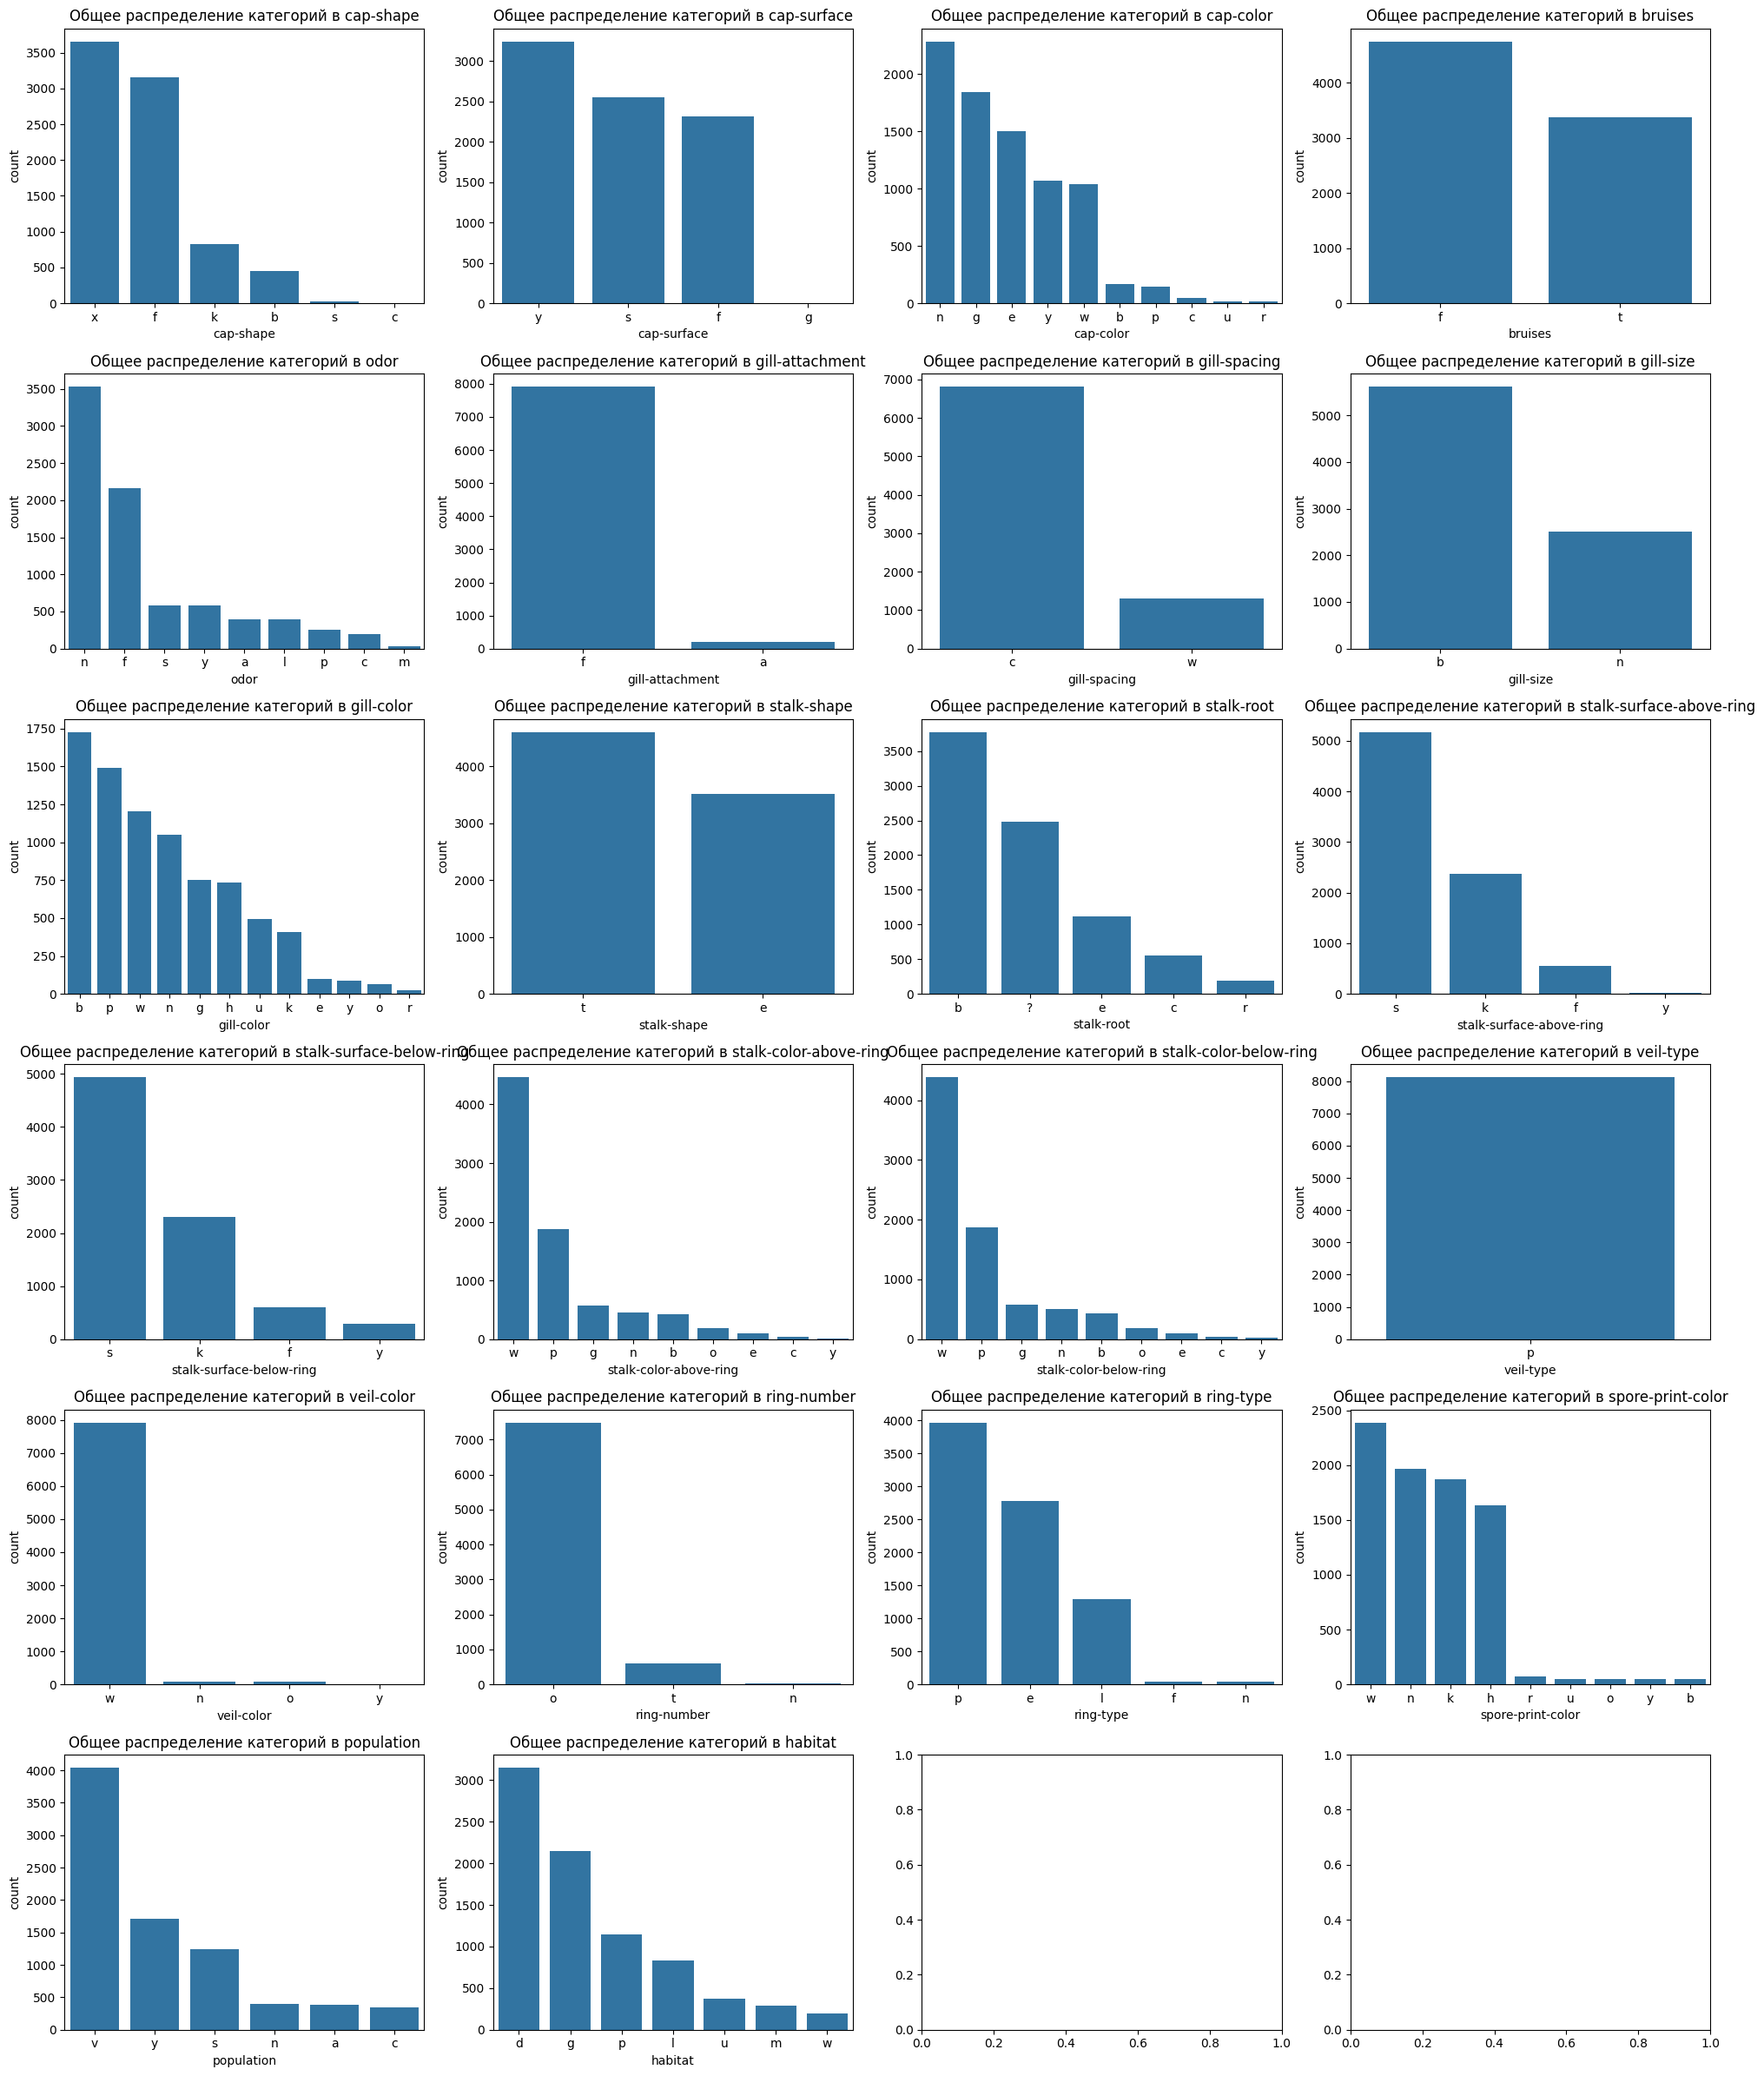

In [11]:
fig, axes = plt.subplots(6, 4, figsize=(20, 24))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Общее распределение категорий в {feature}')
plt.tight_layout()

_Здесь дополнительно можно увидеть распределение значений для каждого признака. То есть можно посмотреть какие значения частые, а каие редкие для каждого признака._

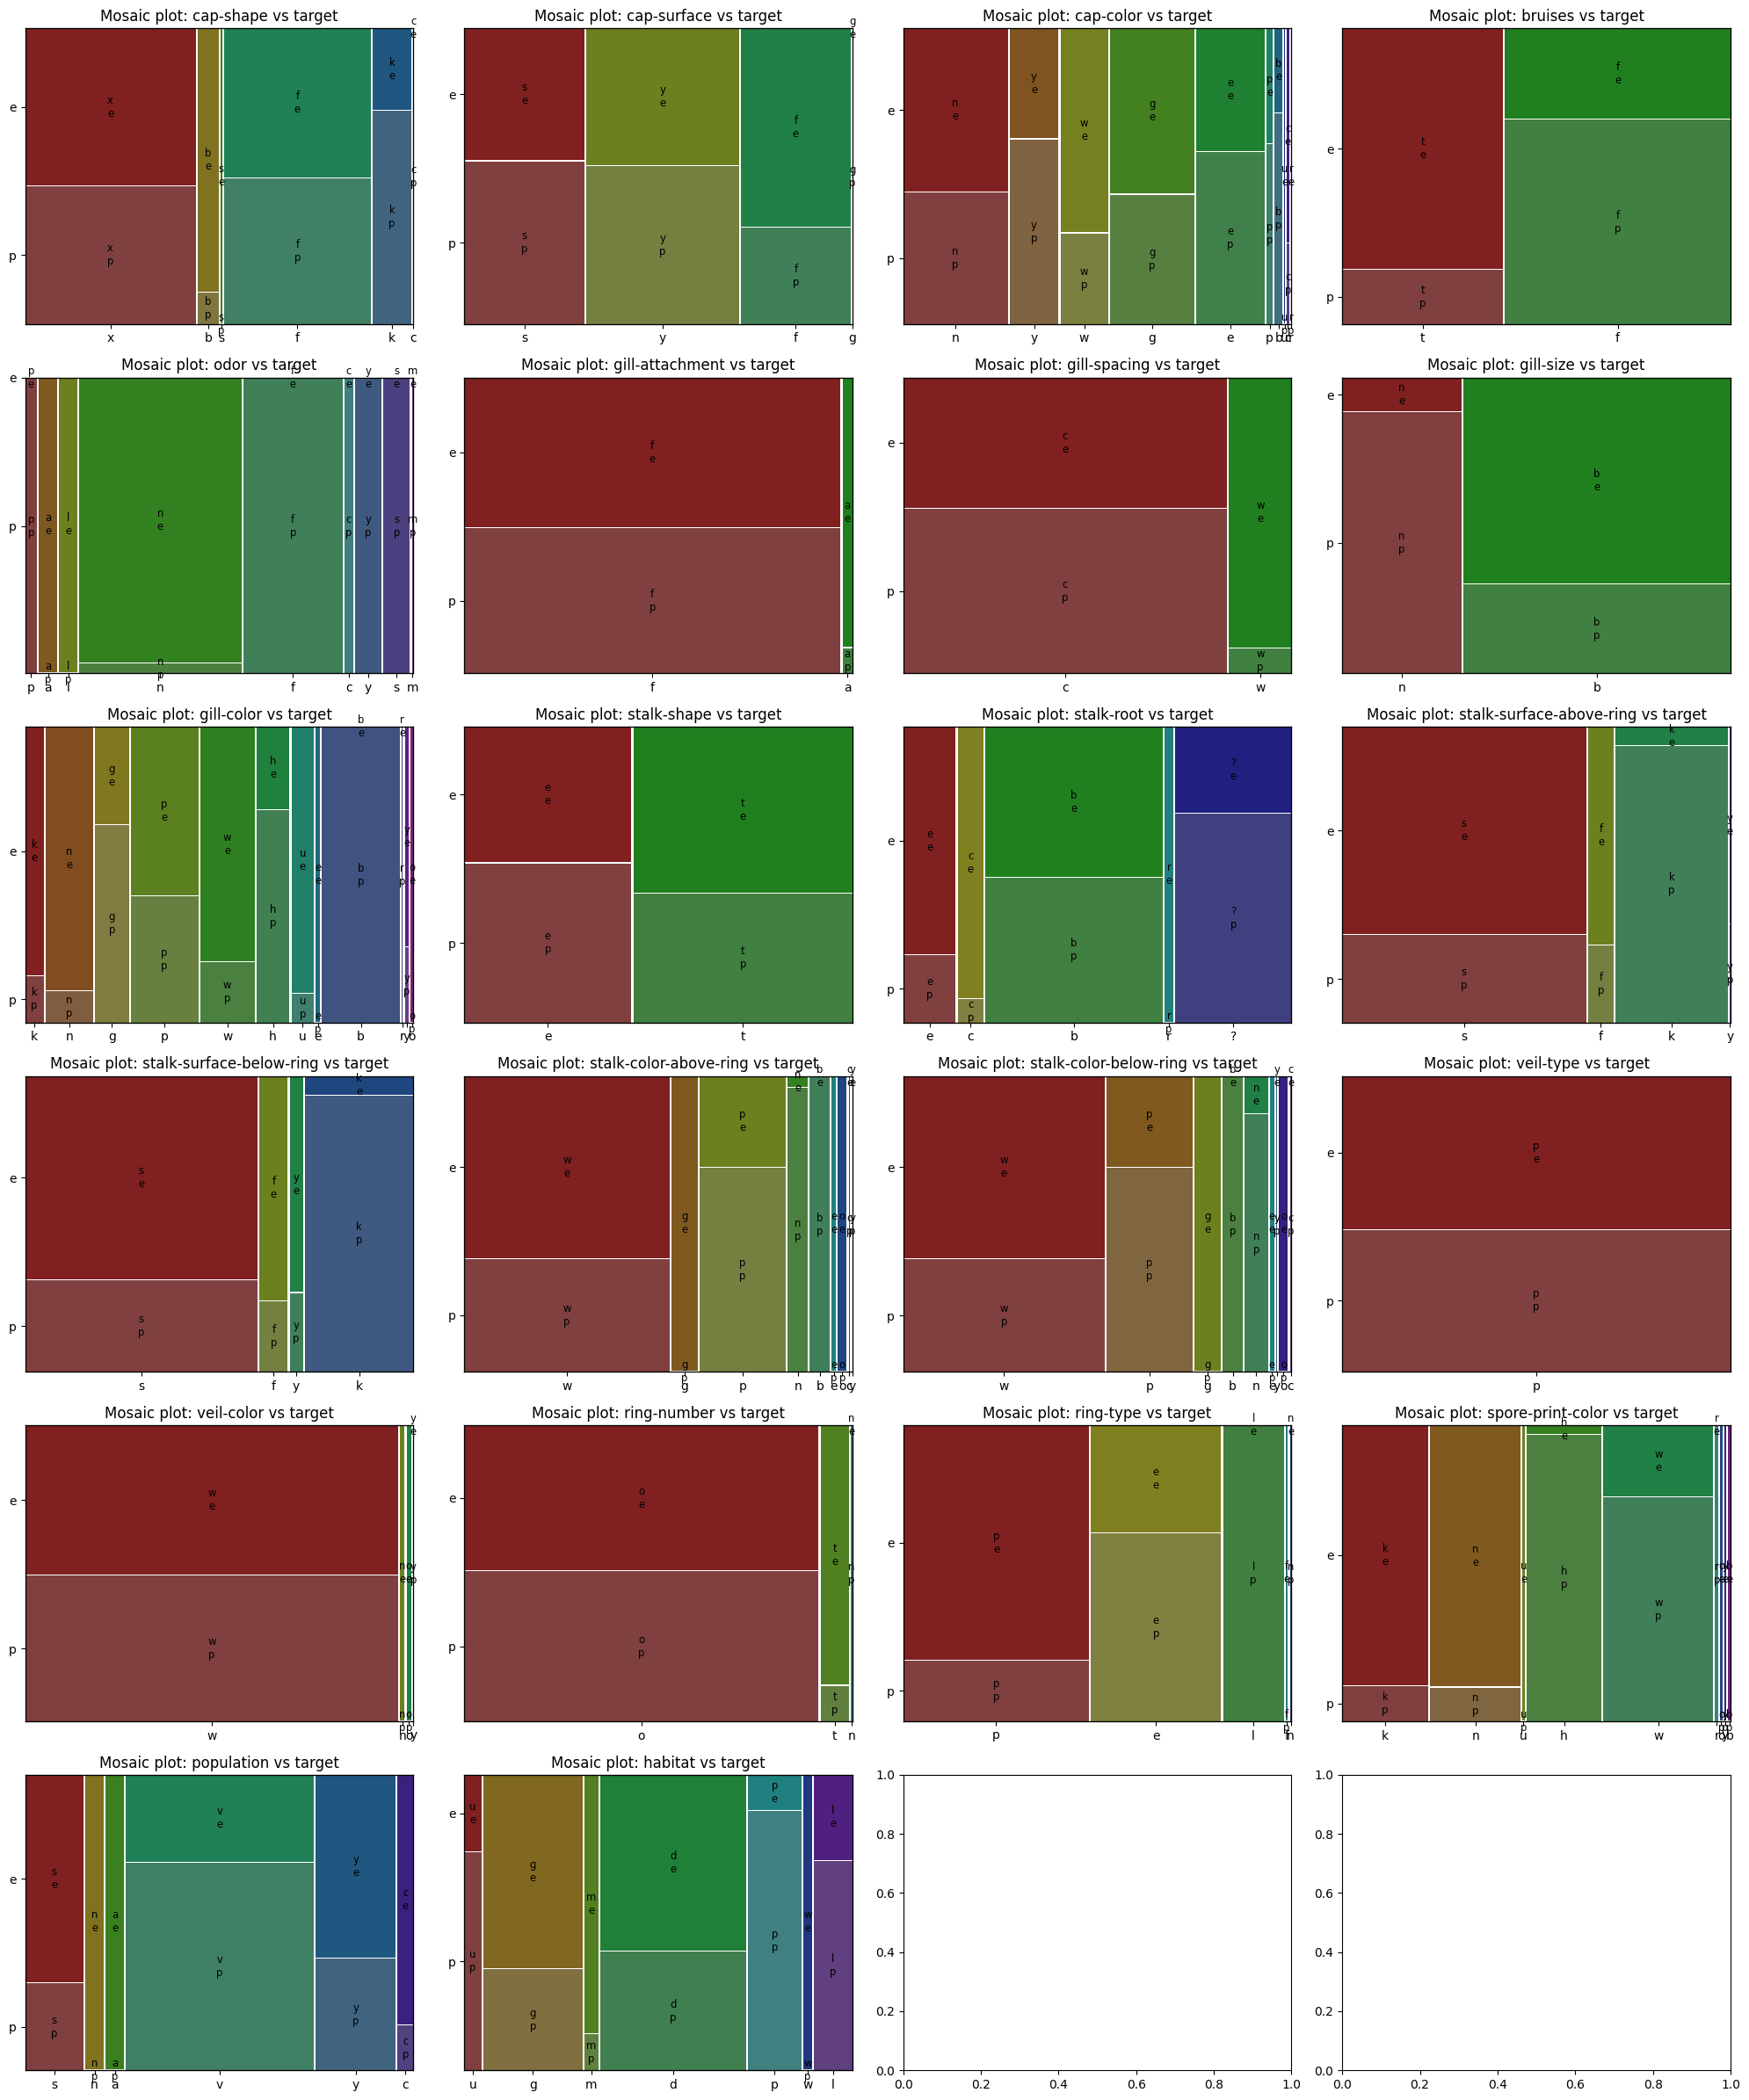

In [12]:
from statsmodels.graphics.mosaicplot import mosaic

fig, axes = plt.subplots(6, 4, figsize=(20, 24))
axes = axes.flatten()

for i, feature in enumerate(features):
    mosaic(df, [feature, 'class'],ax=axes[i])
    axes[i].set_title(f'Mosaic plot: {feature} vs target')
plt.tight_layout()


_Мозаичный график - очень классная штука. По сути он объединяет в себе два предыдущих построенных графика. По нему можно оценить и частоту значений признака и посмотреть, собственно, на пропорции относительно целевой переменной._

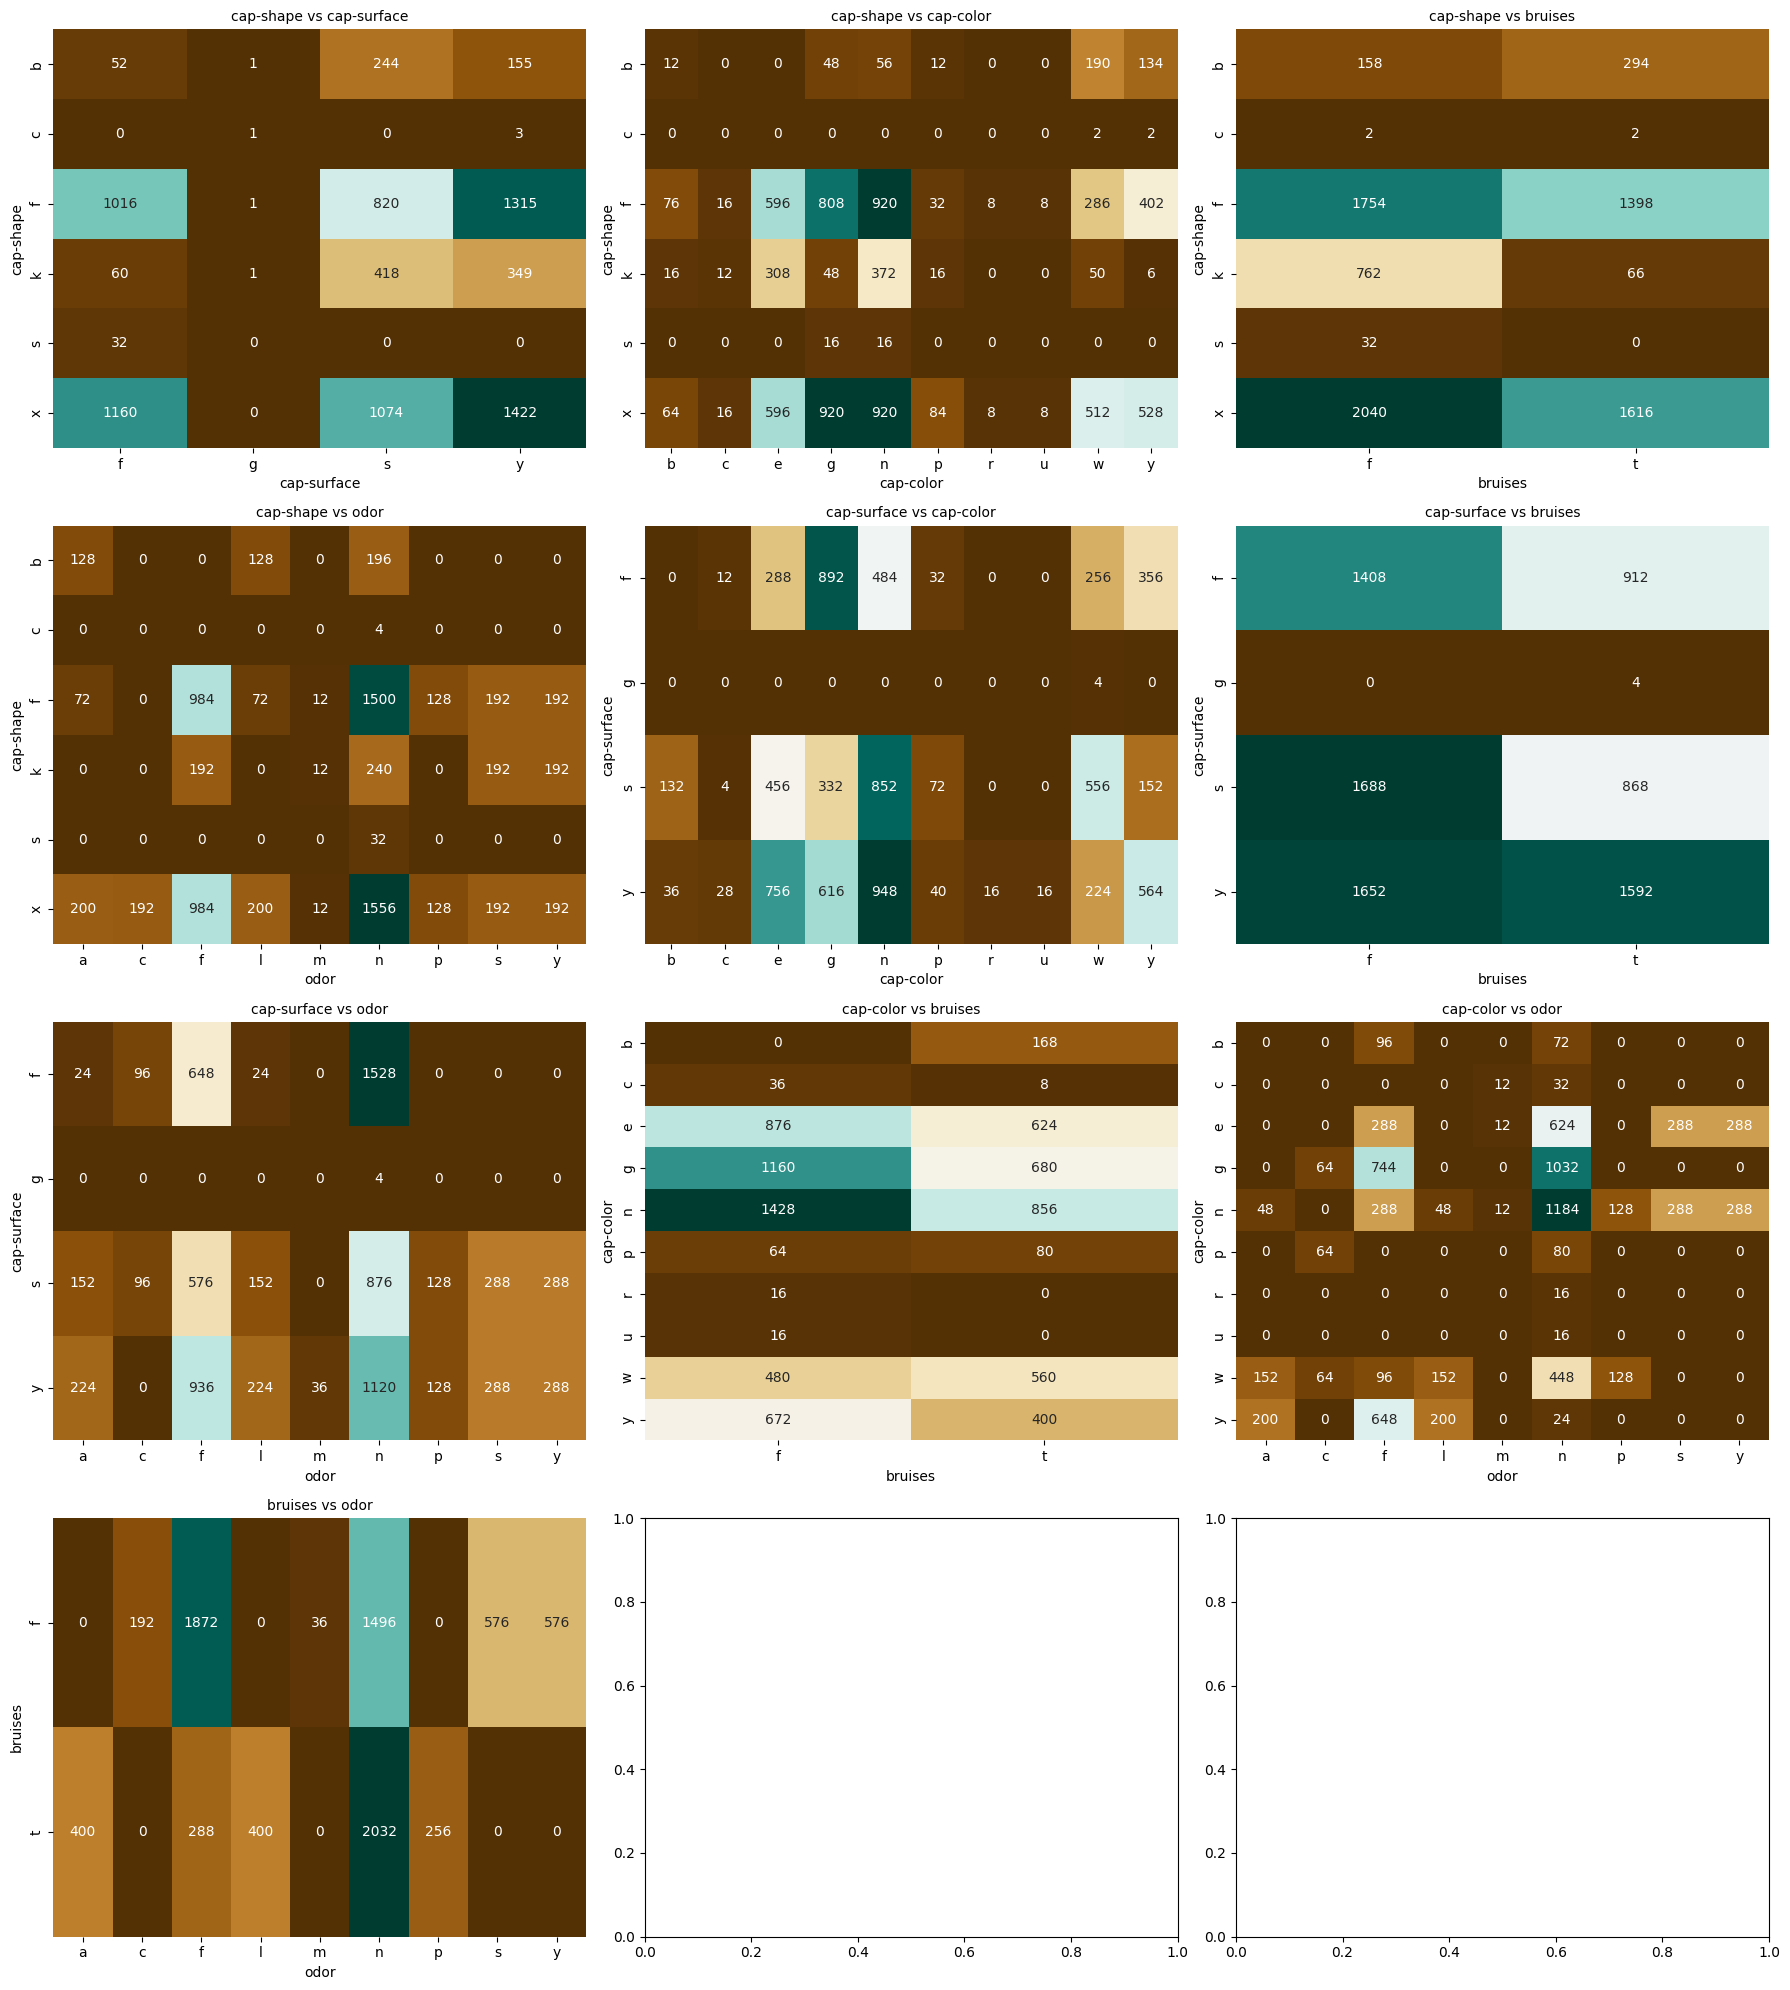

In [13]:
MAX_UNIQUES = 10
selected_pairs = []

usable_features = ['cap-shape','cap-surface','cap-color','bruises','odor']

for i, f1 in enumerate(usable_features):
    for j, f2 in enumerate(usable_features):
        if j <= i:
            continue
        if df[f1].nunique() <= MAX_UNIQUES and df[f2].nunique() <= MAX_UNIQUES:
            selected_pairs.append((f1, f2))

ncols = 3
nrows = (len(selected_pairs) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
axes = axes.flatten()

for i, (f1, f2) in enumerate(selected_pairs):
    ax = axes[i]
    heat_data = pd.crosstab(df[f1], df[f2])
    sns.heatmap(heat_data, annot=True, fmt='d', cmap='BrBG', ax=ax, cbar=False)
    ax.set_title(f'{f1} vs {f2}', fontsize=10)
    ax.set_xlabel(f2)
    ax.set_ylabel(f1)
    
plt.tight_layout()

_Здесь взяли первые 5 признаков и построили для них статистику "частых пар" значений. Можно видеть, какие комбинации чаще всего встречаются. На этой основе можно создавать новые признаки объединяя наиболее "перекошенные" фичи в одну характеристику._

In [14]:
import category_encoders as ce

encoder = ce.CountEncoder()
X_mushroom = encoder.fit_transform(X_mushroom)
X_mushroom.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,3656,2556,2284,3376,256,7914,6812,2512,408,3516,...,4936,4464,4384,8124,7924,7488,3968,1872,1248,368
1,3656,2556,1072,3376,400,7914,6812,5612,408,3516,...,4936,4464,4384,8124,7924,7488,3968,1968,400,2148
2,452,2556,1040,3376,400,7914,6812,5612,1048,3516,...,4936,4464,4384,8124,7924,7488,3968,1968,400,292
3,3656,3244,1040,3376,256,7914,6812,2512,1048,3516,...,4936,4464,4384,8124,7924,7488,3968,1872,1248,368
4,3656,2556,1840,4748,3528,7914,1312,5612,408,4608,...,4936,4464,4384,8124,7924,7488,2776,1968,384,2148


In [15]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_mushroom = encoder.fit_transform(y_mushroom)

C:\Users\Abara\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Теперь перейдем к предсказанию типа опухолей с помощью деревьев решений.

Проведем train/test сплит

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_diagnosis, y_diagnosis, test_size=0.2, random_state=1)

In [17]:
y_train

,diagnosis
408,1
4,1
307,0
386,0
404,0
...,...
129,1
144,0
72,1
235,0


Поэкспериментируем с деревом решений из библиотеки sklearn. 

In [18]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)

In [19]:
len(X_test)

114

In [20]:
tree.predict_proba(X_test)[:, 1]

array([0.83333333, 0.26666667, 0.        , 0.4375    , 0.4375    ,
       1.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.83333333, 1.        , 0.        , 0.4375    ,
       0.03333333, 0.        , 0.        , 0.26666667, 1.        ,
       0.        , 0.        , 1.        , 0.        , 0.83333333,
       0.26666667, 0.        , 1.        , 1.        , 0.4375    ,
       1.        , 0.        , 1.        , 0.83333333, 0.        ,
       0.        , 0.4375    , 0.        , 0.26666667, 0.        ,
       0.        , 0.26666667, 0.03333333, 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 0.03333333,
       0.        , 0.        , 0.4375    , 0.        , 0.        ,
       0.        , 0.26666667, 0.83333333, 0.03333333, 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.03333

In [21]:
tree.score(X_test, y_test)
#metrics.roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])

0.8421052631578947

[Text(0.5, 0.875, 'x[22] <= 106.05\ngini = 0.468\nsamples = 455\nvalue = [285, 170]'),
 Text(0.3, 0.625, 'x[27] <= 0.117\ngini = 0.064\nsamples = 271\nvalue = [262, 9]'),
 Text(0.4, 0.75, 'True  '),
 Text(0.2, 0.375, 'x[10] <= 0.405\ngini = 0.008\nsamples = 241\nvalue = [240, 1]'),
 Text(0.1, 0.125, 'gini = 0.0\nsamples = 211\nvalue = [211, 0]'),
 Text(0.3, 0.125, 'gini = 0.064\nsamples = 30\nvalue = [29, 1]'),
 Text(0.4, 0.375, 'gini = 0.391\nsamples = 30\nvalue = [22, 8]'),
 Text(0.7, 0.625, 'x[6] <= 0.086\ngini = 0.219\nsamples = 184\nvalue = [23, 161]'),
 Text(0.6, 0.75, '  False'),
 Text(0.6, 0.375, 'gini = 0.492\nsamples = 32\nvalue = [18, 14]'),
 Text(0.8, 0.375, 'x[20] <= 17.675\ngini = 0.064\nsamples = 152\nvalue = [5, 147]'),
 Text(0.7, 0.125, 'gini = 0.278\nsamples = 30\nvalue = [5, 25]'),
 Text(0.9, 0.125, 'gini = 0.0\nsamples = 122\nvalue = [0, 122]')]

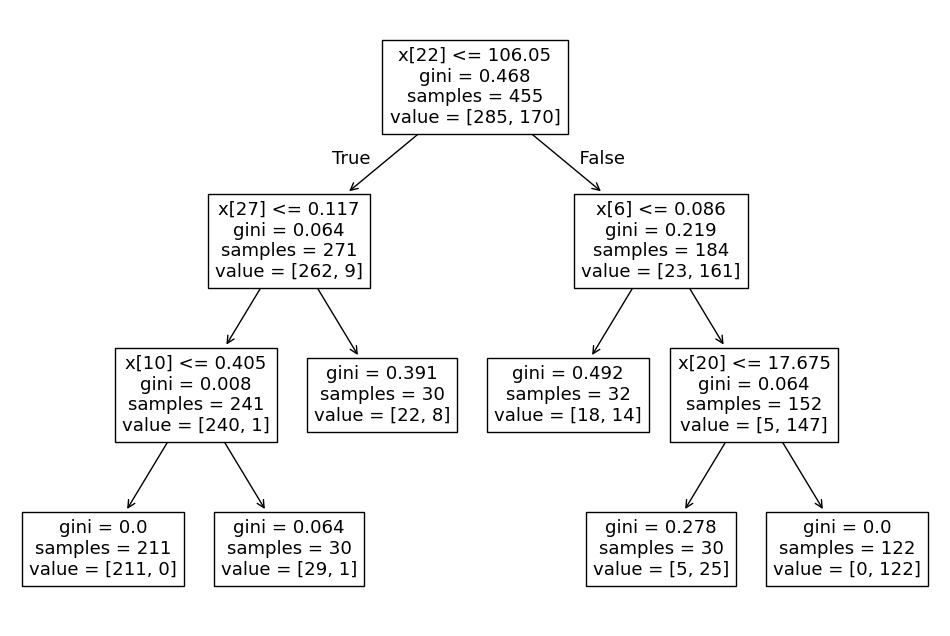

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_tree(tree, ax=ax)

Рассмотрим другие значения гиперпараметров

[Text(0.5, 0.875, 'x[22] <= 106.05\ngini = 0.468\nsamples = 455\nvalue = [285, 170]'),
 Text(0.25, 0.625, 'x[27] <= 0.159\ngini = 0.064\nsamples = 271\nvalue = [262, 9]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[27] <= 0.135\ngini = 0.03\nsamples = 265\nvalue = [261, 4]'),
 Text(0.0625, 0.125, 'gini = 0.008\nsamples = 254\nvalue = [253, 1]'),
 Text(0.1875, 0.125, 'gini = 0.397\nsamples = 11\nvalue = [8, 3]'),
 Text(0.375, 0.375, 'x[1] <= 16.22\ngini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.75, 0.625, 'x[21] <= 20.645\ngini = 0.219\nsamples = 184\nvalue = [23, 161]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[22] <= 116.8\ngini = 0.388\nsamples = 19\nvalue = [14, 5]'),
 Text(0.5625, 0.125, 'gini = 0.0\nsamples = 13\nvalue = [13, 0]'),
 Text(0.6875, 0.125, 'gini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.875, 0.375, 'x[7] <

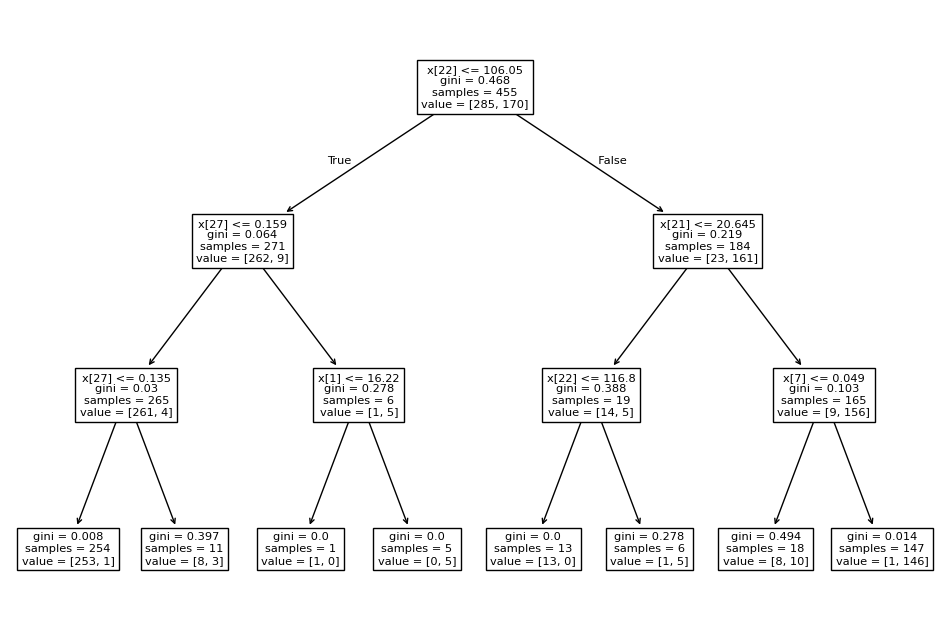

In [23]:
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_tree(tree_gini.fit(X_train, y_train), ax=ax)

In [24]:
print('Training-set accuracy score: {0:0.4f}'. format(tree_gini.score(X_train, y_train)))
print('Test-set accuracy score: {0:0.4f}'. format(tree_gini.score(X_test, y_test)))

Training-set accuracy score: 0.9692
Test-set accuracy score: 0.9123


Попробуем вместо Джини использовать энтропию

[Text(0.5, 0.875, 'x[22] <= 105.15\nentropy = 0.953\nsamples = 455\nvalue = [285, 170]'),
 Text(0.25, 0.625, 'x[27] <= 0.135\nentropy = 0.176\nsamples = 266\nvalue = [259, 7]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[10] <= 0.643\nentropy = 0.037\nsamples = 252\nvalue = [251, 1]'),
 Text(0.0625, 0.125, 'entropy = 0.0\nsamples = 249\nvalue = [249, 0]'),
 Text(0.1875, 0.125, 'entropy = 0.918\nsamples = 3\nvalue = [2, 1]'),
 Text(0.375, 0.375, 'x[21] <= 25.94\nentropy = 0.985\nsamples = 14\nvalue = [8, 6]'),
 Text(0.3125, 0.125, 'entropy = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.4375, 0.125, 'entropy = 0.811\nsamples = 8\nvalue = [2, 6]'),
 Text(0.75, 0.625, 'x[27] <= 0.151\nentropy = 0.578\nsamples = 189\nvalue = [26, 163]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[21] <= 19.91\nentropy = 0.998\nsamples = 53\nvalue = [25, 28]'),
 Text(0.5625, 0.125, 'entropy = 0.0\nsamples = 13\nvalue = [13, 0]'),
 Text(0.6875, 0.125, 'entropy = 0.881\nsamples = 40\nvalue 

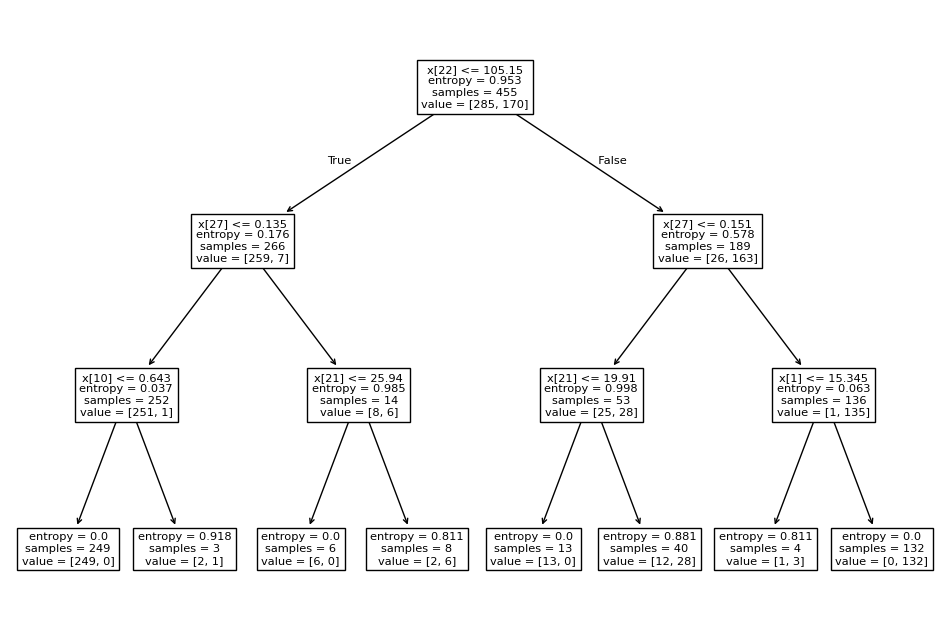

In [25]:
tree_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree_en.fit(X_train, y_train)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_tree(tree_en, ax=ax)

In [26]:
print('Training set score: {:.4f}'.format(tree_en.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(tree_en.score(X_test, y_test)))

Training set score: 0.9648
Test set score: 0.9123


Перейдем теперь к датасету с грибами

[Text(0.4666666666666667, 0.9166666666666666, 'x[4] <= 2844.0\ngini = 0.499\nsamples = 6499\nvalue = [3388.0, 3111.0]'),
 Text(0.26666666666666666, 0.75, 'x[10] <= 838.0\ngini = 0.288\nsamples = 3660\nvalue = [637, 3023]'),
 Text(0.3666666666666667, 0.8333333333333333, 'True  '),
 Text(0.13333333333333333, 0.5833333333333334, 'x[17] <= 3762.0\ngini = 0.098\nsamples = 580\nvalue = [550, 30]'),
 Text(0.06666666666666667, 0.4166666666666667, 'gini = 0.0\nsamples = 30\nvalue = [0, 30]'),
 Text(0.2, 0.4166666666666667, 'gini = 0.0\nsamples = 550\nvalue = [550, 0]'),
 Text(0.4, 0.5833333333333334, 'x[6] <= 4062.0\ngini = 0.055\nsamples = 3080\nvalue = [87, 2993]'),
 Text(0.3333333333333333, 0.4166666666666667, 'x[3] <= 4062.0\ngini = 0.495\nsamples = 158\nvalue = [87.0, 71.0]'),
 Text(0.26666666666666666, 0.25, 'gini = 0.0\nsamples = 87\nvalue = [87, 0]'),
 Text(0.4, 0.25, 'gini = 0.0\nsamples = 71\nvalue = [0, 71]'),
 Text(0.4666666666666667, 0.4166666666666667, 'gini = 0.0\nsamples = 2922\

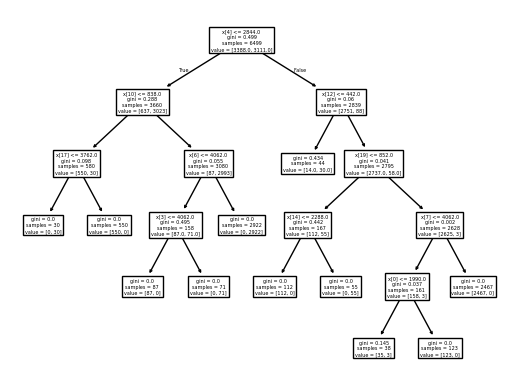

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_mushroom, y_mushroom, test_size=0.2, random_state=1)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
plot_tree(tree.fit(X_train, y_train))

In [28]:
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)
print('Training-set accuracy score: {0:0.4f}'. format(tree.score(X_train, y_train)))
print('Test-set accuracy score: {0:0.4f}'. format(tree.score(X_test, y_test)))

Training-set accuracy score: 0.9974
Test-set accuracy score: 0.9957


Сравним, как разные классификаторы строят границы разделения. Для начала посмотрим на общую картинку, как в зависимости от настроек будет отличаться дерево.

In [29]:
classifiers = {
    "DT_basic_3": DecisionTreeClassifier(max_depth=3),
    "DT_basic_5_no_min": DecisionTreeClassifier(max_depth=5),
    "DT_basic_5": DecisionTreeClassifier(max_depth=5, min_samples_leaf=30),
    "DT_gini_3": DecisionTreeClassifier(max_depth=3, criterion='gini',  min_samples_leaf=30),
    "DT_gini_5": DecisionTreeClassifier(max_depth=5, criterion='gini', min_samples_leaf=30),
    "DT_entropy_3": DecisionTreeClassifier(max_depth=3, criterion='entropy', min_samples_leaf=30),
    "DT_entropy_5": DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_leaf=30),
    "DT_entropy_5_no_min": DecisionTreeClassifier(max_depth=5, criterion='entropy'),
}
    

columns =  X_diagnosis.columns[:2] 
columns_mushroom = ['gill-color', 'cap-color']

datasets = [
    (X_diagnosis[columns].to_numpy(), y_diagnosis.to_numpy()),
    (X_mushroom[columns_mushroom].to_numpy(), y_mushroom),
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1)
]


In [30]:
def set_grid(ax, i, j, x_min, x_max, y_min, y_max):
    ax[i][j].set_xlim(x_min, x_max)
    ax[i][j].set_ylim(y_min, y_max)
    ax[i][j].set_xticks(())
    ax[i][j].set_yticks(())

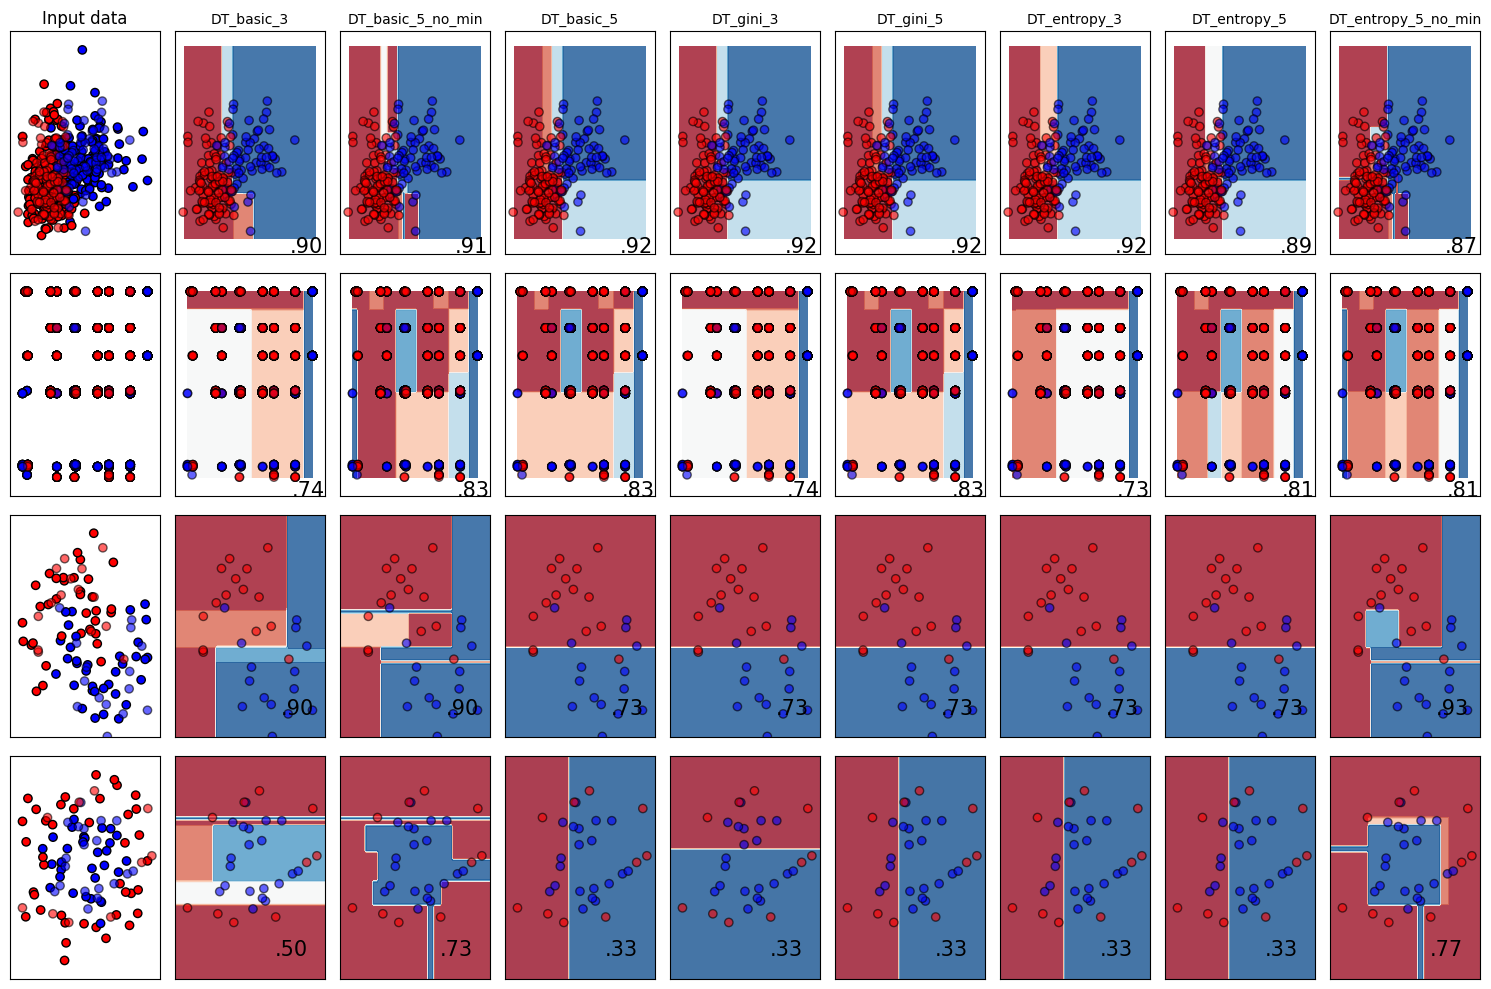

In [31]:
fig, ax = plt.subplots(len(datasets), len(classifiers)+1, figsize=(15, 10))

for dataset_num, data in enumerate(datasets):
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42
      )
    diff_x = X_train[:, 0].max() - X_train[:, 0].min()
    diff_y = X_train[:, 1].max() - X_train[:, 1].min()
    x_min, x_max = X_train[:, 0].min() - diff_x*0.1, X_train[:, 0].max() + diff_x*0.1
    y_min, y_max = X_train[:, 1].min() - diff_y*0.1, X_train[:, 1].max() + diff_y*0.1


    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    if dataset_num == 0:
          ax[dataset_num][0].set_title("Input data")
            
    # Plot the training points
    ax[dataset_num][0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax[dataset_num][0].scatter(
      X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    set_grid(ax, dataset_num, 0, x_min, x_max, y_min, y_max)
    
    # iterate over classifiers
    for cls_num, (name, clf) in enumerate(classifiers.items(), start=1):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X_train, cmap=cm, alpha=0.8, ax=ax[dataset_num][cls_num], eps=0.5
        )
        
        # Plot the training points
        #ax[dataset_num][cls_num].scatter(
        #    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        #)
        
        # Plot the testing points
        ax[dataset_num][cls_num].scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        set_grid(ax, dataset_num, cls_num, x_min, x_max, y_min, y_max)
        if dataset_num == 0:
            ax[dataset_num][cls_num].set_title(name, fontdict={'fontsize': 10, 'fontweight': 'medium'})
            
        ax[dataset_num][cls_num].text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )

plt.tight_layout()
plt.show()

Деревья решений легко переобучаются. В теории, каждая точка набора может сформировать листовую вершину. Поэтому всегда надо аккуратно выбирать гиперпараметры, влияющие на разбиение дерева. Кроме того, деревья чувствительны к обучающе выборке. Даже небольшая ее пертурбация может привести к очень серьезным изменениям в классификаторе.

**Задание**: 
1) Постройте несколько графиков, чтобы оценить, как будет выглядить разделение плоскости в зависимости от 
    - минимального количества объектов в листе
    - максимальной глубины дерева
  К увеличению или уменьшению качества на обучающей выборке приводит увеличение глубины дерева? А на тестовой? 
2) Постройте несколько графиков, чтобы оценить, как будет выглядить разделение плоскости в зависимости от подвыборки. Выберите из вашего обучающего набора 90% семплов с разными сидами и посмотрите, как поменяются предсказания.

_Влияние минимального количества объектов в листе и максимальной глубины дерева:_

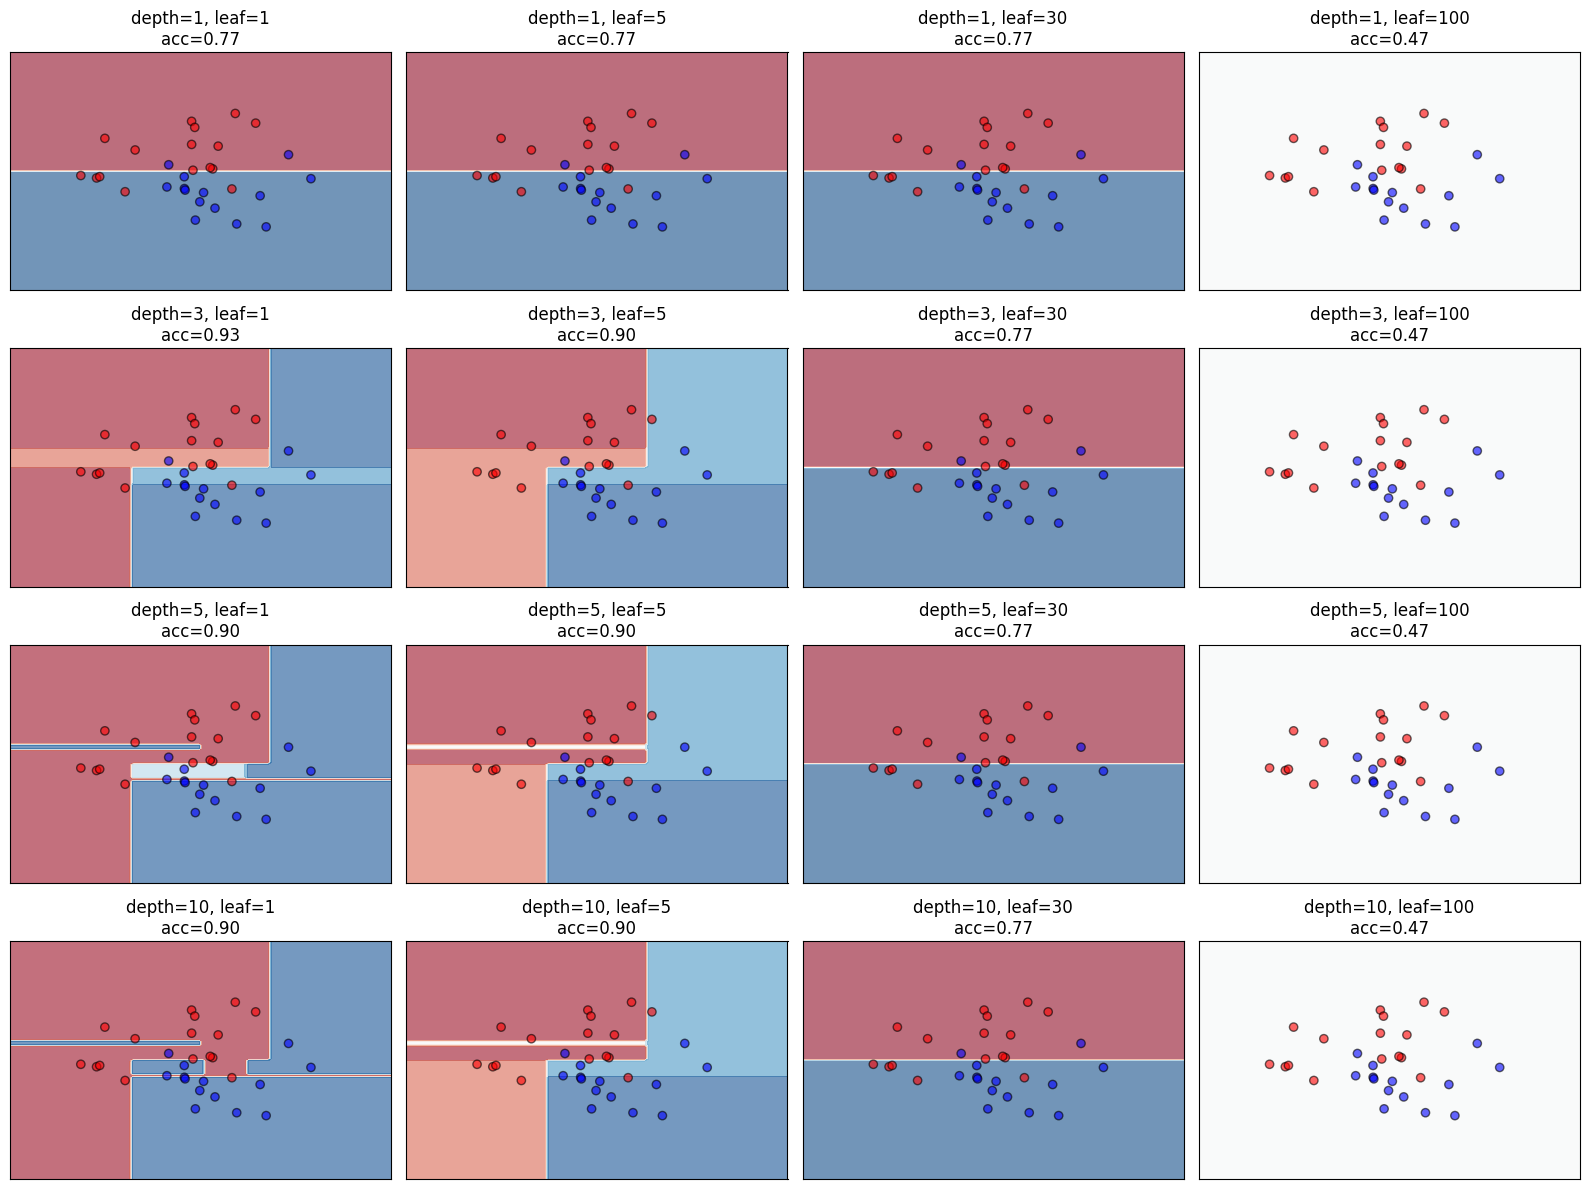

In [32]:
# Возьмем make_moons
X, y = make_moons(noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

depths = [1, 3, 5, 10]
leaf_sizes = [1, 5, 30, 100]

fig, ax = plt.subplots(len(depths), len(leaf_sizes), figsize=(16, 12))
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

for i, depth in enumerate(depths):
    for j, leaf in enumerate(leaf_sizes):
        clf = make_pipeline(
            StandardScaler(),
            DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, random_state=0)
        )
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        DecisionBoundaryDisplay.from_estimator(clf, X_train, ax=ax[i, j], cmap=cm, alpha=0.6)
        ax[i, j].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)
        ax[i, j].set_xticks(())
        ax[i, j].set_yticks(())
        ax[i, j].set_title(f"depth={depth}, leaf={leaf}\nacc={score:.2f}")

plt.tight_layout()


_Чем больше глубина дерева, тем более детализованно оно пытается разделить данные. При слишком большом leaf деления вообще не происходит._

_Эксперименты с выборками по разным сидам:_

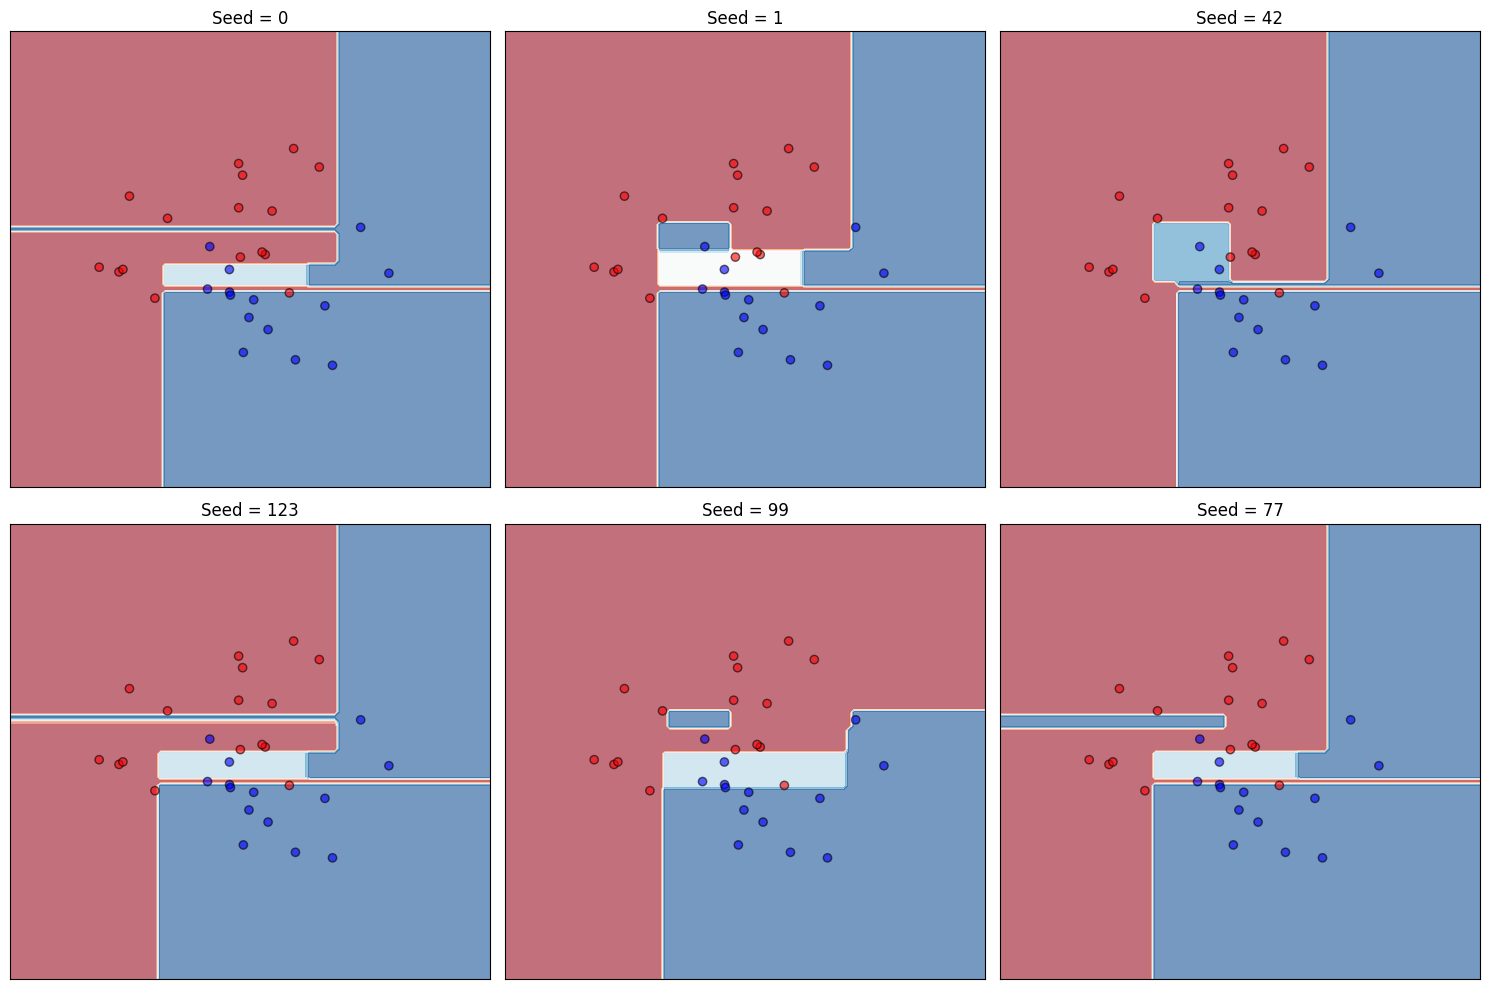

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
seeds = [0, 1, 42, 123, 99, 77]
axes = axes.flatten()

for i, seed in enumerate(seeds):
    X_sub, _, y_sub, _ = train_test_split(X_train, y_train, train_size=0.9, random_state=seed)
    
    clf = make_pipeline(
        StandardScaler(),
        DecisionTreeClassifier(max_depth=5, random_state=0)
    )
    clf.fit(X_sub, y_sub)
    
    DecisionBoundaryDisplay.from_estimator(clf, X_train, ax=axes[i], cmap=cm, alpha=0.6)
    axes[i].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)
    axes[i].set_title(f"Seed = {seed}")
    axes[i].set_xticks(())
    axes[i].set_yticks(())

plt.tight_layout()

_На разных случайных подвыборках предсказания деревьев отличаются (то есть деревья как правило неустойчивы)._

**Задание:**
  Для датасета mushrooms сравните, как меняется точность и переобучение для деревьев с разными кодировками признаков. Можете зафиксировать остальные параметры. 

In [34]:
X = X_mushroom.copy()
y = y_mushroom.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_params = dict(max_depth=5, min_samples_leaf=30, random_state=0)

In [35]:
# Оценим по accuracy:
def evaluate_encoder(encoder_name, encoder_transformer):
    pipe = make_pipeline(
        encoder_transformer,
        DecisionTreeClassifier(**tree_params)
    )
    pipe.fit(X_train, y_train)
    
    acc_train = pipe.score(X_train, y_train)
    acc_test = pipe.score(X_test, y_test)
    
    print(f"{encoder_name:<15} | Train: {acc_train:.4f} | Test: {acc_test:.4f} | Gap: {acc_train - acc_test:.4f}")
    return acc_train, acc_test


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import CountEncoder

print("Кодировка       | Точность Train| Точность Test| Переобучение")

# OrdinalEncoder
evaluate_encoder("OrdinalEncoder",
                 ColumnTransformer([("ord", OrdinalEncoder(), X.columns)], remainder="drop"))

# OneHotEncoder
evaluate_encoder("OneHotEncoder",
                 ColumnTransformer([("ohe", OneHotEncoder(handle_unknown="ignore"), X.columns)], remainder="drop"))

# CountEncoder
evaluate_encoder("CountEncoder",
                 CountEncoder(cols=X.columns))


Кодировка       | Точность Train| Точность Test| Переобучение
OrdinalEncoder  | Train: 0.9921 | Test: 0.9938 | Gap: -0.0018
OneHotEncoder   | Train: 0.9972 | Test: 0.9967 | Gap: 0.0005
CountEncoder    | Train: 0.9921 | Test: 0.9938 | Gap: -0.0018


(0.992085824832923, 0.9938474159146842)